In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from torch import nn
from torch.utils.data import DataLoader,Dataset
import scipy

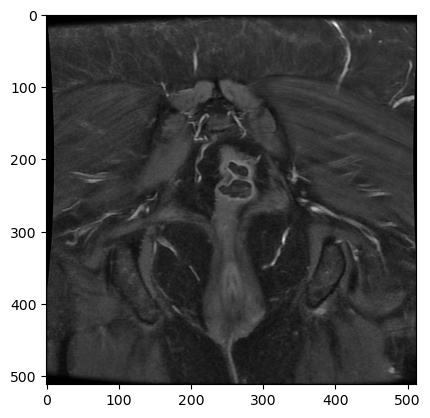

In [73]:
from pydicom import dcmread
file_img = dcmread("DICOM/PA0/ST0/SE16/IM2")
img_original = dcmread("DICOM/PA0/ST0/SE16/IM2").pixel_array
plt.imshow(img_original, cmap='gray')

/var/folders/b4/9cg_tkrn3256x3hcybpxqnpw0000gn/T/ipykernel_9665/4024183864.py:9: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  img = scipy.ndimage.interpolation.zoom(img, real_resize_factor, mode='nearest')


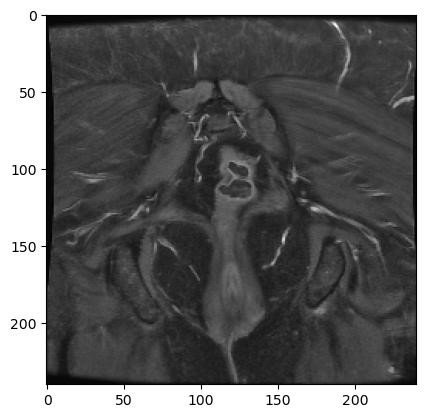

In [42]:
def sampling(img, scan, new_spacing=[1,1]):
    # when scanning there are different pixel spaces across all scans so to normalise it we've made a function to get all of it to a base spacing of 1x1x1
    spacing = np.array(list(scan.PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img.shape
    new_spacing = spacing / real_resize_factor
    img = scipy.ndimage.interpolation.zoom(img, real_resize_factor, mode='nearest')
    return img, new_spacing

def normalize(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    arr = (arr - arr_min) / (arr_max - arr_min) * 255
    return arr

normalized_img = normalize(img)
# plt.imshow(normalized_img, cmap='gray')
sampled_img, new_spacing = sampling(normalized_img, file_img)
plt.imshow(sampled_img, cmap='gray')

In [6]:
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [69]:
class Reducer(nn.Module):
    def __init__(self,transform):
        super().__init__()
        self.encoder = nn.Sequential(
            #input = 1x512x512
            nn.Conv2d(1,10,3,stride=1,padding="same"), # 10x510x510
            nn.ReLU(),
            nn.MaxPool2d(2), # 10x255x255
            nn.Conv2d(10,16,3,padding="same"), # 16x253x253
            nn.ReLU(),
            nn.MaxPool2d(2) #16x126x126 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,10,2,stride=2), #10x252x252
            nn.ReLU(),
            nn.ConvTranspose2d(10,1,2,stride=2), #1x504x504
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x = self.encoder(x)
        # x = self.decoder(x)
        return x

In [70]:
import torch
from torchvision.datasets import ImageFolder

import torchvision.transforms as transforms
import PIL.Image as Image
# Define the path to the data folder
data_folder = 'data/test'

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('L')),
    transforms.ToTensor(),
    transforms.Resize((512,512)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the dataset
dataset = ImageFolder(data_folder, transform=transform)

# Create the data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# create a training loop to train the autoencoder model
model = Reducer(transform).to('mps')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for i,(img,y) in enumerate(data_loader):
        img = img.to('mps')
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Batch {i}, Loss: {loss.item()}")
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Batch 0, Loss: 1.384944200515747
Epoch 1, Loss: 1.442897915840149
Batch 0, Loss: 1.4490472078323364
Epoch 2, Loss: 1.3813492059707642
Batch 0, Loss: 1.4100521802902222
Epoch 3, Loss: 1.3092412948608398
Batch 0, Loss: 1.3845629692077637
Epoch 4, Loss: 1.3333410024642944
Batch 0, Loss: 1.2958648204803467
Epoch 5, Loss: 1.1789212226867676


In [99]:
img_original.max()

2059

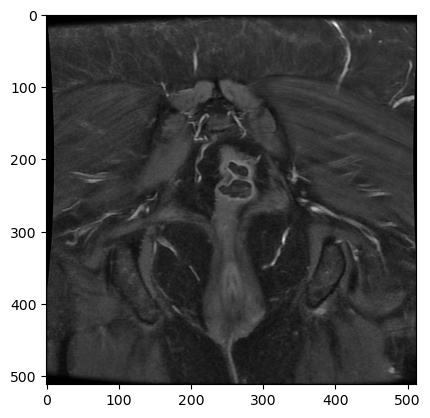

In [104]:
model.eval()
plt.imshow(img_original,cmap='gray')
img_reshape = np.array(img_original.reshape(1,512,512))
normalized_img = normalize(img_original)
pil_img = Image.fromarray(normalized_img)

In [105]:
output = model(transform(pil_img).unsqueeze(0).to('mps'))

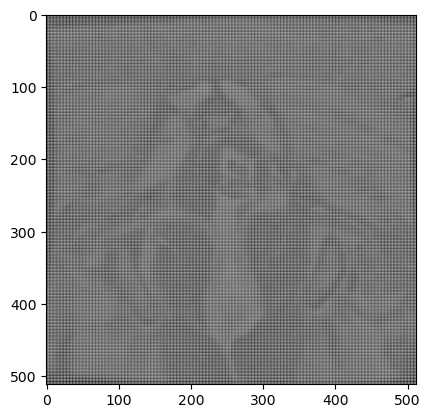

In [109]:
show_output = output.squeeze().detach().cpu().numpy()
plt.imshow(show_output,cmap='gray')